In [8]:
# load rig config json
import json
import numpy as np

with open('../configs/rig_config.json', 'r') as file:
    rig_config = json.load(file)

In [11]:
keys_of_interest = [
    'gpu_mode', # string
    'calibration_exposure_time', # float
    'experiment_exposure_time', # float
    'physical_arena_radius', # float
    'projector_space_arena_center', # (2,) float array
    'projector_space_arena_radius', # float
    'calibration_detail', # int
    'camera_space_arena_center', # (2,) float array
    'camera_space_arena_radius', # float
    'camera_to_physical_scaling', # float
    'physical_to_camera_scaling', # float
    'projection_space_detail_markers', # (N, 2) float array
    'projector_space_detail_markers', # (N, 2) float array
    'fitted_projection_space_detail_markers', # (N, 2) float array
    'fitted_projector_space_detail_markers', # (N, 2) float array
    'interpolated_projection_space_detail_markers', # (f(N), 2) float array
    'interpolated_projector_space_detail_markers' # (f(N), 2) float array
    'H_refined', # (3, 3) float array
    'H_projector_distortion_corrected', # (3, 3) float array
    'distortion_corrected_projection_space_detail_markers', # (f(N), 2) float array
    'projector_correction_method', # string
    'camera_correction_method', # string
    'H_refined_mapx', # (H, W) float array
    'H_refined_mapy', # (H, W) float array
    'H_projector_distortion_corrected_homography_mapx', # (H, W) float array
    'H_projector_distortion_corrected_homography_mapy', # (H, W) float array
    'H_projector_distortion_corrected_distortion_mapx', # (H, W) float array
    'H_projector_distortion_corrected_distortion_mapy', # (H, W) float array
    'H_refined_inv_mapx', # (H, W) float array
    'H_refined_inv_mapy', # (H, W) float array
    'H_projector_distortion_corrected_homography_inv_mapx', # (H, W) float array
    'H_projector_distortion_corrected_homography_inv_mapy', # (H, W) float array
    'H_projector_distortion_corrected_distortion_inv_mapx', # (H, W) float array
    'H_projector_distortion_corrected_distortion_inv_mapy', # (H, W) float array
]


In [13]:
import h5py

with h5py.File('../configs/rig_config.h5', 'w') as h5file:
    for key in keys_of_interest:
        if key in rig_config:
            value = rig_config[key]
            if isinstance(value, list):
                value = np.array(value)
            # Use compression and chunking for large arrays
            if isinstance(value, np.ndarray) and value.size > 1000:
                h5file.create_dataset(key, data=value, compression="gzip", chunks=True)
            else:
                h5file.create_dataset(key, data=value)

In [7]:
import sys
import time
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from pypylon import pylon
from basler_camera import BaslerCamera, list_basler_cameras
import subprocess as sp
import os
import traceback

def get_gpu_memory():
    command = "nvidia-smi --query-gpu=memory.free --format=csv"
    memory_free_info = sp.check_output(command.split()).decode('ascii').split('\n')[:-1][1:]
    memory_free_values = [int(x.split()[0]) for i, x in enumerate(memory_free_info)]
    return memory_free_values

# dont use gpu
# tf.config.set_visible_devices([], 'GPU')

# Set GPU memory growth
gpus = tf.config.list_physical_devices('GPU')
print("GPUs Available:")
for gpu in gpus:
    print(gpu)
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      print("Setting memory growth for GPU:", gpu)
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

# list available cameras
print("Cameras Available:")
cameras = list_basler_cameras()


# Acquisition Parameters
EXPOSURE_TIME, GAIN, CAMERA_FORMAT, WIDTH, HEIGHT, OFFSETX, OFFSETY = 7000.0, 0.0, "Mono8", 2048, 2048, 340, 0

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7f173d0aa760>>
Traceback (most recent call last):
  File "/home/rutalab/mambaforge/envs/flyprojection/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 781, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


ModuleNotFoundError: No module named 'basler_camera'

In [2]:
# get a single image from the camera
with BaslerCamera(
    index=0,
    FPS=100,
    EXPOSURE_TIME=EXPOSURE_TIME,
    GAIN=GAIN,
    WIDTH=WIDTH,
    HEIGHT=HEIGHT,
    OFFSETX=OFFSETX,
    OFFSETY=OFFSETY,
    TRIGGER_MODE="Continuous",
    CAMERA_FORMAT=CAMERA_FORMAT,
    record_video=False,
    video_output_path=None,
    video_output_name=None,
    lossless=True,
    debug=False,
) as camera:
    camera.start()
    image = camera.get_array()
    camera.stop()

Trigger mode set to Continuous. FPS will be ignored.
Getting camera...
a2A2448-105g5m_40490701
Found 1 cameras.
Camera a2A2448-105g5m_40490701 selected.
Registered continuous acquisition configuration.
MaxNumBuffer set to 763200. Acquisitions will be limited to 2 hours. To change, modify the code.
Camera initialized.
Exposure time set to 7000.0 microseconds.
Gain set to 0.0 dB.
Set width to 2048, height to 2048, offset to (340, 0).
Camera initialized.


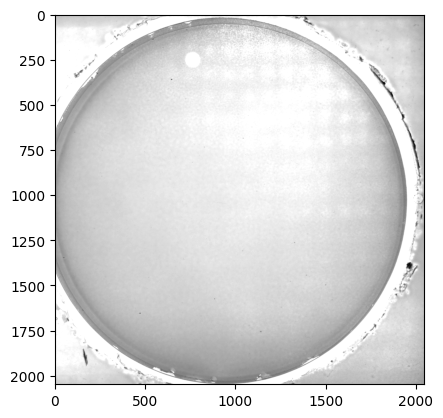

In [3]:
plt.imshow(image, cmap="gray")

In [4]:
QUADRANT = False

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 2048, 2048, 32)    320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 1024, 1024, 32)   0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 1024, 1024, 64)    18496     
                                                                 
 conv2d_2 (Conv2D)           (None, 1024, 1024, 64)    36928     
                                                                 
 up_sampling2d (UpSampling2D  (None, 2048, 2048, 64)   0         
 )                                                               
                                                                 
 conv2d_3 (Conv2D)           (None, 2048, 2048, 32)    1

2024-09-19 12:43:01.713829: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8204
2024-09-19 12:43:02.272488: W tensorflow/stream_executor/gpu/asm_compiler.cc:230] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.9
2024-09-19 12:43:02.272507: W tensorflow/stream_executor/gpu/asm_compiler.cc:233] Used ptxas at ptxas
2024-09-19 12:43:02.272592: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


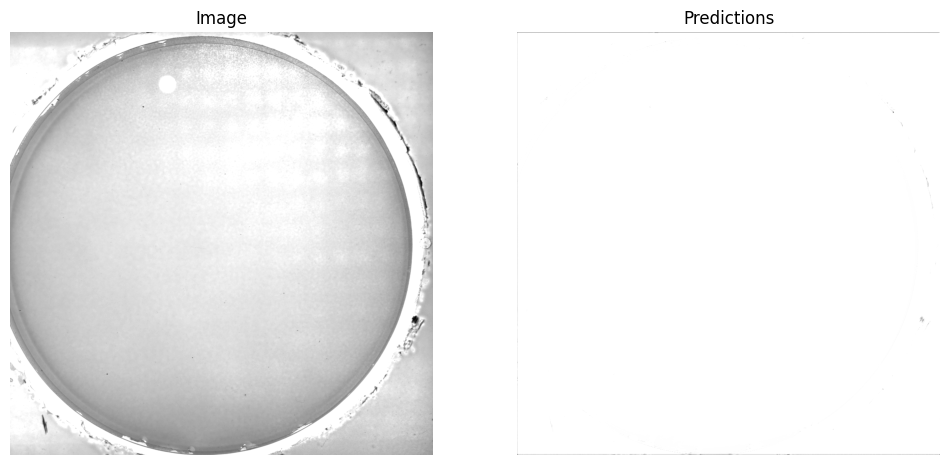

In [5]:
# create a random convolutional neural network for testing

# create a unet model
model = tf.keras.models.Sequential(
    [
        # Encoder
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(WIDTH//2, HEIGHT//2, 1) if QUADRANT else (WIDTH, HEIGHT, 1)),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        
        # Decoder
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.UpSampling2D((2, 2)),
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')
    ]
)


# compile the model
model.compile(
    optimizer='adam', # optimizer
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), # loss function
    metrics=['accuracy'] # metrics
)

# print model summary
model.summary()

# break image into 4 quadrants to create a batch of 4 images
image_ = image.reshape(1, WIDTH, HEIGHT, 1)
if QUADRANT:
    image_ = np.concatenate([image_[:, :WIDTH//2, :HEIGHT//2], image_[:, WIDTH//2:, :HEIGHT//2], image_[:, :WIDTH//2, HEIGHT//2:], image_[:, WIDTH//2:, HEIGHT//2:]], axis=0)
print(image_.shape)

predictions = model.predict(image_).squeeze()

# plot the image and the predictions
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(image, cmap='gray')
ax[0].set_title("Image")
ax[0].axis('off')
# reconstruct the image
if QUADRANT:
    predictions = np.concatenate([
        np.concatenate([predictions[0], predictions[2]], axis=1),
        np.concatenate([predictions[1], predictions[3]], axis=1)
    ], axis=0)# split the image into 4 quadrants
            # image = image.reshape(1, WIDTH, HEIGHT, 1)
            # if QUADRANT:
            #     image = np.concatenate([image[:, :WIDTH//2, :HEIGHT//2], image[:, WIDTH//2:, :HEIGHT//2], image[:, :WIDTH//2, HEIGHT//2:], image[:, WIDTH//2:, HEIGHT//2:]], axis=0)
            # # put the image on the gpu
            # image = tf.convert_to_tensor(image, dtype=tf.float32)
            # # repeat the image to match the batch size
            # # pass the image through the model
            # if BATCH_SIZE > 1:
            #     image = tf.repeat(image, BATCH_SIZE, axis=0)
            # predictions = model.predict(image, verbose=0)

In [7]:
# create an acquisition + prediction loop

BATCH_SIZE = 1
DRAW = True
MAX_FRAMES = 1000

update_period = 1 # seconds

previous_time = time.perf_counter()
last_display = time.perf_counter() - 1.1*update_period

fps = np.zeros(MAX_FRAMES)

# setup live frame rate and gpu memory plot
if DRAW:
    %matplotlib qt
    fig, ax = plt.subplots(1, 1, figsize=(12,3))
    ax.set_title("Resource Usage")
    ax.set_xlabel("Frame")
    ax.set_ylabel("FPS (Hz)", color='k')
    ax.grid()
    line1, = ax.plot([], [], 'k-')
    plt.tight_layout()
    plt.ion()
    plt.show()



# WARM UP THE GPU
start_time = time.perf_counter()
while time.perf_counter() - start_time < 10:
    image = np.random.rand(1, WIDTH//2, HEIGHT//2, 1) if QUADRANT else np.random.rand(1, WIDTH, HEIGHT, 1)
    image = tf.convert_to_tensor(image, dtype=tf.float32)
    image = tf.repeat(image, BATCH_SIZE, axis=0)
    predictions = model.predict(image, verbose=0)

# dont use the gpu for this
with BaslerCamera(
    index=0,
    FPS=100,
    EXPOSURE_TIME=EXPOSURE_TIME,
    GAIN=GAIN,
    WIDTH=WIDTH,
    HEIGHT=HEIGHT,
    OFFSETX=OFFSETX,
    OFFSETY=OFFSETY,
    TRIGGER_MODE="Continuous",
    CAMERA_FORMAT=CAMERA_FORMAT,
    record_video=False,
    video_output_path=None,
    video_output_name=None,
    lossless=True,
    debug=False,
) as camera:
    camera.start()
    try:
        frame_count = 0
        while True:
            image = camera.get_array()
            # split the image into 4 quadrants
            image = image.reshape(1, WIDTH, HEIGHT, 1)
            if QUADRANT:
                image = np.concatenate([image[:, :WIDTH//2, :HEIGHT//2], image[:, WIDTH//2:, :HEIGHT//2], image[:, :WIDTH//2, HEIGHT//2:], image[:, WIDTH//2:, HEIGHT//2:]], axis=0)
            # put the image on the gpu
            image = tf.convert_to_tensor(image, dtype=tf.float32)
            # repeat the image to match the batch size
            # pass the image through the model
            if BATCH_SIZE > 1:
                image = tf.repeat(image, BATCH_SIZE, axis=0)
            predictions = model.predict(image, verbose=0)
            # track frame rate
            current_time = time.perf_counter()
            frame_rate = 1 / (current_time - previous_time)
            previous_time = current_time
            fps[frame_count] = frame_rate
            frame_count += 1
            if current_time - last_display > update_period and DRAW:
                last_display = current_time
                # update the plot
                line1.set_xdata(np.arange(frame_count))
                line1.set_ydata(fps[:frame_count])
                ax.relim()
                ax.autoscale_view()
                fig.canvas.draw()
                fig.canvas.flush_events()
            if frame_count >= MAX_FRAMES:
                break
    except KeyboardInterrupt:
        pass
    except Exception as e:
        # get stack trace and save to file
        with open("error.txt", "w") as f:
            f.write(str(e))
            f.write("\n")
            f.write(str(sys.exc_info()))
            f.write("\n")
            f.write(traceback.format_exc())
    # save the data
    np.save("fps.npy", fps)
    camera.stop()

Trigger mode set to Continuous. FPS will be ignored.
Getting camera...
a2A2448-105g5m_40490701
Found 1 cameras.
Camera a2A2448-105g5m_40490701 selected.
Registered continuous acquisition configuration.
MaxNumBuffer set to 763200. Acquisitions will be limited to 2 hours. To change, modify the code.
Camera initialized.
Exposure time set to 7000.0 microseconds.
Gain set to 0.0 dB.
Set width to 2048, height to 2048, offset to (340, 0).
Camera initialized.


In [7]:
plt.plot(fps)